# Latent neighbors EIG path with all baselines for MNIST digits prediction: example using a convolutional neural network

In this notebook, we will generate attributions using latent neighbors IG (H-N-IG) and baselines:
1. k-means
2. median
3. close
4. random
5. encoded-zero
We will compute some baselines (k-means, median, close and random) in original feature space and encode-zero baseline in the latent space. Latent space refers to the encoded representation that is input to the decoder of an autoencoder. We assume models are run using tensorflow library. 

First, we will load all the relevant packages.

In [22]:
import time
import argparse
import numpy as np
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from visualization_lib import Visualize, pil_image, ConvertToColor, ConvertToColor_img
from tensorflow.python.saved_model import tag_constants
from digits_data_preprocessing import read_input_data_cnn, get_samples, get_neighbors_data, get_neighbors_data_cnn
from eig.interpreters.DeepNetworkModel import DeepNetworkModel
from eig.interpreters.LatentModel import LatentModel
from eig.interpreters.LatentNeighborsInterpreter import LatentNeighborsInterpreter
from eig.interpreters.LatentNeighborsInterpreterLatentBL import LatentNeighborsInterpreterLatentBL
from eig.feature_significance.FeatureSignificance import FeatureSignificance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Now, we will declare all the constants used in this notebook.

In [23]:
NO_OF_POINTS = 250
NO_BASELINES = 3
MAX_SAMPLES = 300
IMAGE_SIZE = 28
TARGET_PSI1 = "digits_softmax"
TARGET_TENSOR = {TARGET_PSI1: "output/digits_softmax/BiasAdd:0"}

Next, we will specify all the paths needed to run the EIG on digits Convolutional neural network (CNN).

In [24]:
encoder_model = "../models/digits/cnn_encoder/"
decoder_model = "../models/digits/cnn_decoder/"
digits_model = "../models/digits/cnn_model/"
save_path = ""
target_type = "digits_softmax"

Read the digits data.

In [25]:
data_dict = read_input_data_cnn()

Data shape: (70000, 28, 28, 1), Data labels: (70000, 10)


Next, we load the Digits CNN model, we assume that the model has been developed using tensorflow.

In [26]:
# Load the digits model
deep_graph = tf.Graph()
deep_sess = tf.compat.v1.Session(graph=deep_graph)
tf.compat.v1.saved_model.loader.load(
    deep_sess,
    [tag_constants.SERVING],
    digits_model
)

# Digit model input and output
target_tensor = deep_graph.get_tensor_by_name(TARGET_TENSOR[target_type])
input_1 = deep_graph.get_tensor_by_name("input:0")

#Initialize the deep neural network object 
deep_model = DeepNetworkModel(deep_sess, ([input_1], None, target_tensor))

INFO:tensorflow:Restoring parameters from ../models/digits/cnn_model/variables/variables


If you want to use baselines or paths in the latent space, specify the encoder and decoder models. 

In [27]:
# Load the encoder model
e_graph = tf.Graph()
e_sess = tf.compat.v1.Session(graph=e_graph)
tf.compat.v1.saved_model.loader.load(
    e_sess,
    [tag_constants.SERVING],
    encoder_model
)

# get the encoder input and output
features_placeholder = e_graph.get_tensor_by_name('input:0')
latent_dimensions = e_graph.get_tensor_by_name('latent/z_mu/BiasAdd:0')

# Load the decoder model
d_graph = tf.Graph()
d_sess = tf.compat.v1.Session(graph=d_graph)
tf.compat.v1.saved_model.loader.load(
    d_sess,
    [tag_constants.SERVING],
    decoder_model
)

# Get the decoder input and output
decoder_placeholder = d_graph.get_tensor_by_name('decoder_input:0')
reconstructed_output = d_graph.get_tensor_by_name('sigmoid_output:0')

# Initialize the autoencoder object with the encoder and decoder input and output.
ae_model = LatentModel(e_sess, d_sess,
                        ([features_placeholder], latent_dimensions, [decoder_placeholder], reconstructed_output))

INFO:tensorflow:Restoring parameters from ../models/digits/cnn_encoder/variables/variables
INFO:tensorflow:Restoring parameters from ../models/digits/cnn_decoder/variables/variables


Initialize the neighbors graph

In [28]:
# Get neighbors data and initalize the neighbors graph
neighbors_data = get_neighbors_data_cnn(data_dict)
paths_latent_neighbors_obj = LatentNeighborsInterpreter.initialize_neighbors_path(neighbors_data,
                                                                                  encoder=ae_model.encoder,
                                                                                  decoder=ae_model.decoder,
                                                                                  encoder_data=None,
                                                                                  decoder_data=None)

neighbors data shape:  (10000, 28, 28, 1)
Populate nearest neighbors graph...
neighbors_data shape:  (10000, 28, 28, 1)
Done.


# Group specific Baselines

Next, we will run latent neighbors IG with group specific baselines (k-means, median, close, random) in the original feature space. 

In [29]:
baseline_type = "median" #can be replaced with: "close", "k-means", "random"

all_attrs = {}
for samples_digit in [5]:
    for baseline_digit in [1, 3, 2]:
        sample_data = get_samples(data_dict, samples_digit, num_samples=300)
        if not baseline_digit == samples_digit:
            print("Sample: {}, Baseline: {}".format(samples_digit, baseline_digit))
            baseline_data = get_samples(data_dict, baseline_digit, num_samples=10000)

            this_key = "baseline_" + str(baseline_digit) + "_sample_digit_" + str(samples_digit)
            baseline_tuple = [baseline_data]
            sample_tuple = [sample_data]
            lni = LatentNeighborsInterpreter(baseline_tuple,
                                             sample_tuple,
                                             encoder_data=None,
                                             decoder_data=None,
                                             other_data_nn=None,
                                             nn_model=deep_model,
                                             autoencoder=ae_model,
                                             baseline_type=baseline_type,
                                             no_baselines=NO_BASELINES,
                                             no_points=NO_OF_POINTS,
                                             neighbor_obj=paths_latent_neighbors_obj)
            attributes_lni = lni.attributions()
            print("Computed attributions for Sample {} and Baseline {}".format(samples_digit, baseline_digit))
            all_attrs[this_key] = attributes_lni[0]

Digit: 5, Data size: (300, 28, 28, 1)
Sample: 5, Baseline: 1
Digit: 1, Data size: (7877, 28, 28, 1)
Computed attributions for Sample 5 and Baseline 1
Digit: 5, Data size: (300, 28, 28, 1)
Sample: 5, Baseline: 3
Digit: 3, Data size: (7141, 28, 28, 1)
Computed attributions for Sample 5 and Baseline 3
Digit: 5, Data size: (300, 28, 28, 1)
Sample: 5, Baseline: 2
Digit: 2, Data size: (6990, 28, 28, 1)
Computed attributions for Sample 5 and Baseline 2


## Feature significance

Once we have attributions, we can find significant features using compute_feature_significance function from the FeatureSignificance class. As CNN model looks at patches instead of individual pixels, we compute feature significance for patches.

Digit: 5, Data size: (800, 28, 28, 1)
(300, 729) (900, 729) (729,)
number of significant features:  160


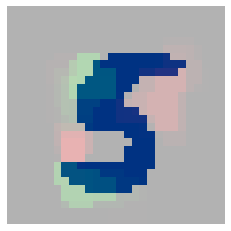

In [31]:
target_key = "baseline_3_sample_digit_5"
target_attributes = [np.abs(all_attrs[target_key])]
sample_data = get_samples(data_dict, 5, num_samples=800)
sample_digits = np.median(sample_data, axis=0)
img = sample_digits.reshape((28,28))*255.

# Summarize attributions for the target class (digit 5 with baseline 3) over a sliding window of size n - p + 1
n = 28
p = 2
filter_size = n - p + 1
target_attributes_class = np.zeros((target_attributes[0].shape[0], filter_size, filter_size, 1))
for j in range(filter_size):
    for k in range(filter_size):
        val = np.sum(target_attributes[0][:, j:j+p, k:k+p, 0], axis=1)
        val = np.sum(val, axis=1)
        target_attributes_class[:, j, k, 0] = val
target_attributes_class = [np.array(target_attributes_class)]

# Summarize attributions for the background (digit 5 with multiple baselines) over a sliding window of size n - p + 1

null_attributes = []
null_keys = ["baseline_3_sample_digit_5",
             "baseline_1_sample_digit_5",
             "baseline_2_sample_digit_5"]

for ii in null_keys:
    target_attributes_all = np.zeros((all_attrs[ii].shape[0], filter_size, filter_size, 1))
    for j in range(filter_size):
        for k in range(filter_size):
            val = np.abs(np.sum(all_attrs[ii][:, j:j+p, k:k+p, 0], axis=1))
            val = np.sum(val, axis=1)
            target_attributes_all[:, j, k, 0] = val
    null_attributes.append(target_attributes_all)

# Rename features according to the new filter size
feature_names = []
for i in range(filter_size):
    feature_this = []
    for j in range(filter_size):
        name = "{}_{}".format(i,j)
        feature_this.append(name)
    feature_names.append(feature_this)
feature_names = np.array(feature_names)

# Intialize object of FeatureSignificance class which contains the function to compute significant features. 
fs = FeatureSignificance()
significant_features_meta = fs.compute_feature_significance(target_attributes_class,
                                                        null_attributes,
                                                        feature_names,
                                                        correction_alpha=0.05,
                                                        correction_method='fdr_bh')

# Mark all the pixels in a significant filter as significant (1)
significant_features_meta = np.array(significant_features_meta[:, 1], dtype=int).reshape((filter_size, filter_size))
significant_features_this = np.zeros((28,28))
for i in range(filter_size):
    for j in range(filter_size):
        if int(significant_features_meta[i, j]) == 1:
            significant_features_this[i:i+p, j:j+p] = 1
important_features = np.array(significant_features_this, dtype=int).flatten()

# Mean attributions with important features
this_key = "baseline_3_sample_digit_5"
attrs = all_attrs[this_key]
attrs_flattened = np.array([np.array(ii).flatten() for ii in attrs])
all_attributions_imp = np.mean(attrs_flattened, axis=0)*np.array(important_features, dtype=int)
attr_imp = all_attributions_imp.reshape((28,28))
img_black = ConvertToColor_img(img, 255.)

attr_imp = ConvertToColor(attr_imp, 1)

# Plot mean attributions with important features
img_val = Visualize(
    attr_imp, img_black, polarity='both',
    clip_above_percentile=100,
    clip_below_percentile=0,
    morphological_cleanup=True,
    outlines=False,
    overlay=True)
img_val = pil_image(img_val)
_= plt.axis('off')
_= plt.imshow(img_val)

# Group agnostic baselines

## Run attributions

Next, we will run latent neighbors IG with group agnostic baseline (encoded_zero) in the latent feature space. 

In [32]:
baseline_type = "encoded_zero"
all_attrs_latent_bl = {}
for samples_digit in [5, 1, 7]:
    sample_data = get_samples(data_dict, samples_digit, num_samples=300)
    this_key = "encoded_zero_sample_digit_" + str(samples_digit)
    print("Sample: {}, Baseline: encoded_zero".format(samples_digit))
    # Pass sample data as baseline to get the data dimensions for encoded_zero baseline
    baseline_tuple = [sample_data, None, None]
    sample_tuple = [sample_data, None, None] 
    lni_lbl = LatentNeighborsInterpreterLatentBL(baseline_tuple,
                                                 sample_tuple,
                                                 encoder_data=None,
                                                 decoder_data=None,
                                                 other_data_nn=None,
                                                 nn_model=deep_model,
                                                 autoencoder=ae_model,
                                                 baseline_type=baseline_type,
                                                 no_baselines=NO_BASELINES,
                                                 no_points=NO_OF_POINTS,
                                                 neighbor_obj=paths_latent_neighbors_obj)
    attributes_lni_lbl = lni_lbl.attributions()
    print("Computed attributions for Sample {} and Baseline encoded_zero".format(samples_digit))
    all_attrs_latent_bl[this_key] = attributes_lni_lbl[0]

Digit: 5, Data size: (300, 28, 28, 1)
Sample: 5, Baseline: encoded_zero
Computed attributions for Sample 5 and Baseline encoded_zero
Digit: 1, Data size: (300, 28, 28, 1)
Sample: 1, Baseline: encoded_zero
Computed attributions for Sample 1 and Baseline encoded_zero
Digit: 7, Data size: (300, 28, 28, 1)
Sample: 7, Baseline: encoded_zero
Computed attributions for Sample 7 and Baseline encoded_zero


## Feature significance

Once we have attributions, we can find significant features using compute_feature_significance function from the FeatureSignificance class. As CNN model looks at patches instead of individual pixels, we compute feature significance for patches.

Digit: 5, Data size: (800, 28, 28, 1)
(300, 729) (900, 729) (729,)
number of significant features:  443


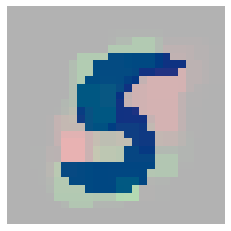

In [33]:
target_key = "encoded_zero_sample_digit_5"
target_attributes = [np.abs(all_attrs_latent_bl[target_key])]
sample_data = get_samples(data_dict, 5, num_samples=800)
sample_digits = np.median(sample_data, axis=0)
img = sample_digits.reshape((28,28))*255.

# Summarize attributions for the target class (digit 5 with baseline 3) over a sliding window of size n - p + 1
n = 28
p = 2
filter_size = n - p + 1
target_attributes_class = np.zeros((target_attributes[0].shape[0], filter_size, filter_size, 1))
for j in range(filter_size):
    for k in range(filter_size):
        val = np.sum(target_attributes[0][:, j:j+p, k:k+p, 0], axis=1)
        val = np.sum(val, axis=1)
        target_attributes_class[:, j, k, 0] = val
target_attributes_class = [np.array(target_attributes_class)]

# Summarize attributions for the background (digit 5 with multiple baselines) over a sliding window of size n - p + 1

null_attributes = []
null_keys = ["encoded_zero_sample_digit_5",
             "encoded_zero_sample_digit_1",
             "encoded_zero_sample_digit_7"]

for ii in null_keys:
    target_attributes_all = np.zeros((all_attrs_latent_bl[ii].shape[0], filter_size, filter_size, 1))
    for j in range(filter_size):
        for k in range(filter_size):
            val = np.abs(np.sum(all_attrs_latent_bl[ii][:, j:j+p, k:k+p, 0], axis=1))
            val = np.sum(val, axis=1)
            target_attributes_all[:, j, k, 0] = val
    null_attributes.append(target_attributes_all)

# Rename features according to the new filter size
feature_names = []
for i in range(filter_size):
    feature_this = []
    for j in range(filter_size):
        name = "{}_{}".format(i,j)
        feature_this.append(name)
    feature_names.append(feature_this)
feature_names = np.array(feature_names)

# Intialize object of FeatureSignificance class which contains the function to compute significant features. 
fs = FeatureSignificance()
significant_features_meta = fs.compute_feature_significance(target_attributes_class,
                                                        null_attributes,
                                                        feature_names,
                                                        correction_alpha=0.05,
                                                        correction_method='fdr_bh')

# Mark all the pixels in a significant filter as significant (1)
significant_features_meta = np.array(significant_features_meta[:, 1], dtype=int).reshape((filter_size, filter_size))
significant_features_this = np.zeros((28,28))
for i in range(filter_size):
    for j in range(filter_size):
        if int(significant_features_meta[i, j]) == 1:
            significant_features_this[i:i+p, j:j+p] = 1
important_features = np.array(significant_features_this, dtype=int).flatten()

# Mean attributions with important features
this_key = "baseline_3_sample_digit_5"
attrs = all_attrs[this_key]
attrs_flattened = np.array([np.array(ii).flatten() for ii in attrs])
all_attributions_imp = np.mean(attrs_flattened, axis=0)*np.array(important_features, dtype=int)
attr_imp = all_attributions_imp.reshape((28,28))
img_black = ConvertToColor_img(img, 255.)

attr_imp = ConvertToColor(attr_imp, 1)

# Plot mean attributions with important features
img_val = Visualize(
    attr_imp, img_black, polarity='both',
    clip_above_percentile=100,
    clip_below_percentile=0,
    morphological_cleanup=True,
    outlines=False,
    overlay=True)
img_val = pil_image(img_val)
_= plt.axis('off')
_= plt.imshow(img_val)